In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min



In [3]:
from google.colab import drive
drive.mount('/content/drive')

# # Optional: if you just loaded the CSV
# file_path = '/Users/wangbeini/Documents/Columbia U/5243-bio/final project/data + codebook/filtered_expression_matrix_by_probe.csv'
# df_sig = pd.read_csv(file_path, index_col=0)

# # Define time point groups
# timepoints = ['0h', '24h', '48h', '72h']
# timepoint_groups = {
#     tp: [col for col in df_sig.columns if f'RANKL_{tp}_' in col]
#     for tp in timepoints
# }


Mounted at /content/drive


In [4]:

df_mean_per_time = pd.DataFrame(index=df_sig.index)

for tp, cols in timepoint_groups.items():
    df_mean_per_time[f'{tp}_mean'] = df_sig[cols].mean(axis=1)


df_mean_per_time.to_csv("expression_probe_mean_per_timepoint.csv")
df_mean_per_time

NameError: name 'df_sig' is not defined

##base line: kmeans cluster##

In [ ]:


# Optional: scale features (important for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_mean_per_time)

# Try k=4 as an example (we'll tune it later)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df_clustered = df_mean_per_time.copy()
df_clustered['cluster'] = cluster_labels

df_clustered.head()


,0h_mean,24h_mean,48h_mean,72h_mean,cluster
0,,,,,
ILMN_1212602,1.922745,1.828810,3.575561,4.425662,3
ILMN_1212605,5.769999,5.885450,5.012978,5.293009,1
ILMN_1212607,2.132698,2.077371,2.196588,2.170909,3
ILMN_1212619,3.207935,2.710071,2.605490,2.719356,3
ILMN_1212625,5.924061,6.743062,5.870514,5.856313,1


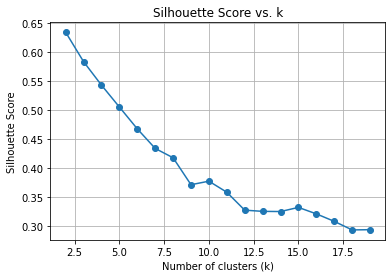

Best k based on silhouette score: 2


In [ ]:

# Try k from 2 to 10 and compute silhouette score
range_k = range(2, 20)
sil_scores = []

for k in range_k:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(range_k, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k")
plt.grid(True)
plt.show()

# Pick the best k (highest silhouette score)
best_k = range_k[sil_scores.index(max(sil_scores))]
print(f"Best k based on silhouette score: {best_k}")


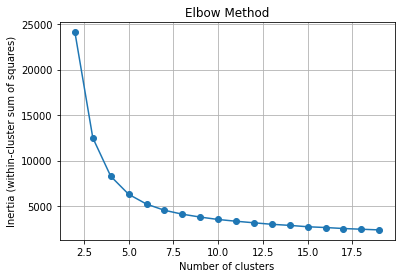

In [ ]:

inertia_list = []

for k in range(2, 20):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia_list.append(km.inertia_)

plt.plot(range(2, 20), inertia_list, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.grid(True)
plt.show()


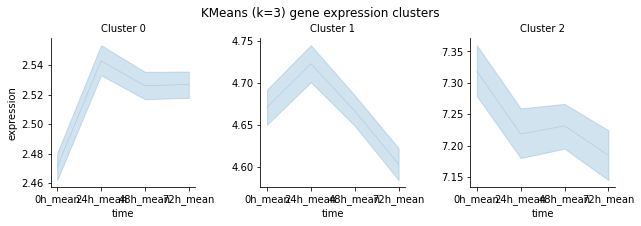

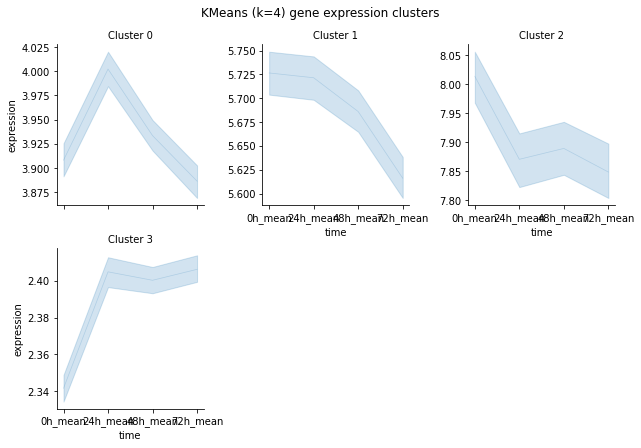

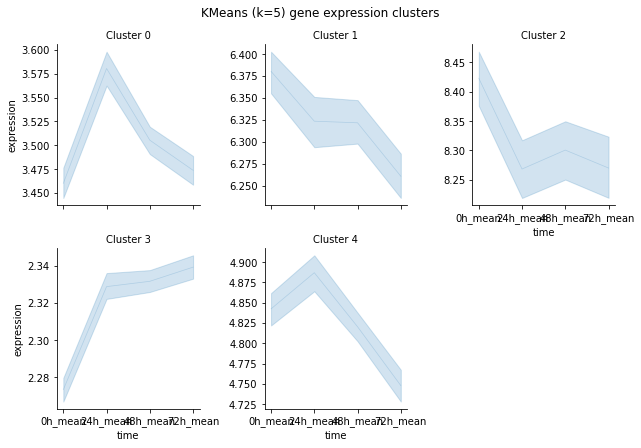

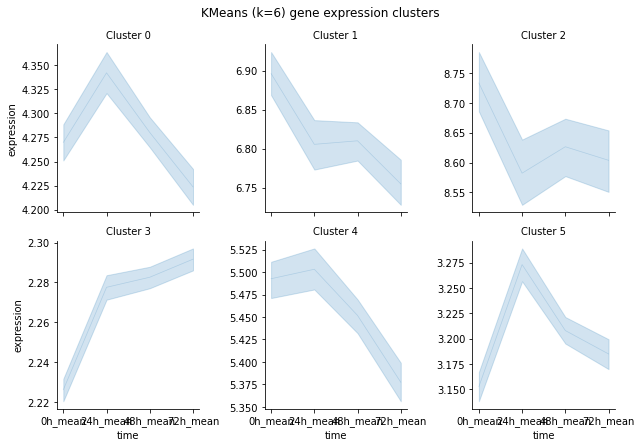

In [ ]:
for k in range(3, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)

    df_clustered = df_mean_per_time.copy()
    df_clustered["cluster"] = labels

    df_melted = df_clustered.reset_index(names='probe').melt(id_vars=["probe", "cluster"],
        value_vars=["0h_mean", "24h_mean", "48h_mean", "72h_mean"],
        var_name="time", value_name="expression")

    g = sns.FacetGrid(df_melted, col="cluster", col_wrap=3, height=3, sharey=False)
    g.map_dataframe(sns.lineplot, x="time", y="expression", alpha=0.2, linewidth=0.7)
    g.set_titles("Cluster {col_name}")
    plt.suptitle(f"KMeans (k={k}) gene expression clusters", y=1.03)
    plt.show()


In [ ]:
# Run KMeans again with the best k
kmeans_best = KMeans(n_clusters=4, random_state=42)
labels_best = kmeans_best.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clustered = df_mean_per_time.copy()
df_clustered['cluster'] = labels_best



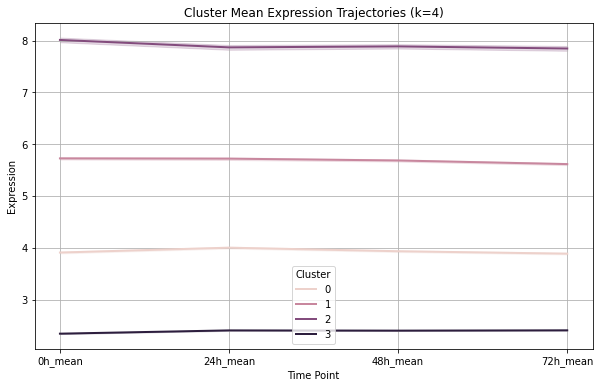

In [ ]:


df_melted = df_clustered.reset_index(names='probe').melt(
    id_vars=["probe", "cluster"],
    value_vars=["0h_mean", "24h_mean", "48h_mean", "72h_mean"],
    var_name="time", value_name="expression"
)

# Plot with confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_melted,
    x="time", y="expression", hue="cluster",
    estimator="mean", errorbar="ci", linewidth=2
)
plt.title("Cluster Mean Expression Trajectories (k=4)")
plt.grid(True)
plt.ylabel("Expression")
plt.xlabel("Time Point")
plt.legend(title="Cluster")
plt.show()


In [ ]:
# Save full list with cluster labels
df_clustered.to_csv("genes_with_clusters_k4.csv")

# Save each cluster separately (optional)
for c in range(4):
    df_clustered[df_clustered['cluster'] == c].to_csv(f"cluster_{c}_genes.csv")




                  0   0h_mean  24h_mean  48h_mean  72h_mean  cluster
0      ILMN_1212602  1.922745  1.828810  3.575561  4.425662        1
1      ILMN_1212605  5.769999  5.885450  5.012978  5.293009        1
2      ILMN_1212607  2.132698  2.077371  2.196588  2.170909        1
3      ILMN_1212619  3.207935  2.710071  2.605490  2.719356        1
4      ILMN_1212625  5.924061  6.743062  5.870514  5.856313        1
...             ...       ...       ...       ...       ...      ...
20690  ILMN_3163539  5.475569  6.896090  6.113329  5.832092        1
20691  ILMN_3163543  2.575353  2.688908  2.633180  2.603446        1
20692  ILMN_3163569  2.438726  2.398066  2.402005  2.433590        1
20693  ILMN_3163572  4.082294  4.632762  5.404209  5.548207        1
20694  ILMN_3163582  2.291066  2.273988  2.297085  2.270885        1

[20695 rows x 6 columns]


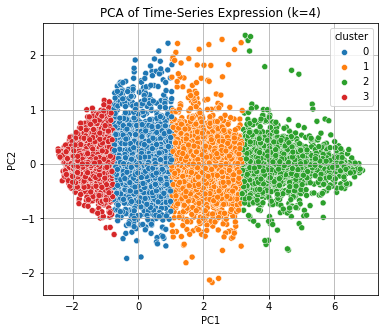

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = cluster_labels

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cluster", palette="tab10")
plt.title("PCA of Time-Series Expression (k=4)")
plt.grid(True)
plt.show()


##Cluster by Plot##

In [ ]:
#Create and Save Expression Plots Per Probe


# Loop through each probe and plot its expression
for probe_id, row in df_mean_per_time.iterrows():
    plt.figure(figsize=(2, 2))
    plt.plot(["0h", "24h", "48h", "72h"], row.values, color="black", linewidth=2)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"probe_plots/{probe_id}.png", dpi=64)
    plt.close()


NameError: name 'df_mean_per_time' is not defined

Time series


In [ ]:
!pip install tslearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00


In [ ]:

import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
import pandas as pd


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/final project/X_scaled.csv"
save_dir = '/content/drive/MyDrive/Colab Notebooks/final project/'
X_scaled = pd.read_csv(file_path, index_col=0)
X_scaled.head()

,0h_mean,24h_mean,48h_mean,72h_mean
Probe_ID,,,,
ILMN_1212602,0.0,-0.093936,1.652815,2.502917
ILMN_1212605,0.0,0.115451,-0.757021,-0.476990
ILMN_1212607,0.0,-0.055327,0.063890,0.038211
ILMN_1212619,0.0,-0.497864,-0.602445,-0.488579
ILMN_1212625,0.0,0.819001,-0.053547,-0.067749


In [ ]:
# X_scaled = X_scaled[:, :, np.newaxis]
X_ts = to_time_series_dataset(X_scaled)

# Step 4: Clustering (you can try "dtw" or "euclidean")
model = TimeSeriesKMeans(n_clusters=27, metric="dtw", random_state=42)
labels = model.fit_predict(X_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Step 5: Attach labels back to your original data
df_with_labels = df_mean_per_time.copy()
df_with_labels["cluster"] = labels

df_with_labels.head()

# Optional: Save to CSV
df_with_labels.to_csv(save_dir + "tslearn_cluster_result.csv")

Cluster by plot


In [10]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm


In [12]:

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your plot image folder (all plots .png)
image_dir = "/content/drive/MyDrive/Colab Notebooks/final project/probe_plots/"
save_dir = '/content/drive/MyDrive/Colab Notebooks/final project/'
# Transform: grayscale, resize, normalize
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

class PlotDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.file_paths = sorted([
            os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".png")
        ])
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert("RGB")
        return self.transform(img)

dataset = PlotDataset(image_dir, transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


Using device: cpu


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 64→32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 32→16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),# 16→8
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 8→16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16→32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),   # 32→64
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z).view(-1, 128, 8, 8)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='mean') * x.shape[0]
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

# Training
vae = VAE(latent_dim=16).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 50

train_losses = []

vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = batch.to(device)
        recon, mu, logvar = vae(batch)
        loss = loss_function(recon, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_val_loss - 1e-4:
        best_val_loss = avg_loss
        epochs_no_improve = 0
        torch.save(vae.state_dict(), "best_vae.pth")  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best loss: {best_val_loss:.4f}")
            break


Epoch 1/50: 100%|██████████| 162/162 [2:07:04<00:00, 47.06s/it]


Epoch 1 | Loss: 0.1980


Epoch 2/50: 100%|██████████| 162/162 [03:12<00:00,  1.19s/it]


Epoch 2 | Loss: 0.1310


Epoch 3/50: 100%|██████████| 162/162 [03:13<00:00,  1.20s/it]


Epoch 3 | Loss: 0.1286


Epoch 4/50: 100%|██████████| 162/162 [03:14<00:00,  1.20s/it]


Epoch 4 | Loss: 0.1276


Epoch 5/50: 100%|██████████| 162/162 [03:14<00:00,  1.20s/it]


Epoch 5 | Loss: 0.1272


Epoch 6/50: 100%|██████████| 162/162 [03:16<00:00,  1.21s/it]


Epoch 6 | Loss: 0.1270


Epoch 7/50: 100%|██████████| 162/162 [03:13<00:00,  1.19s/it]


Epoch 7 | Loss: 0.1268


Epoch 8/50: 100%|██████████| 162/162 [03:17<00:00,  1.22s/it]


Epoch 8 | Loss: 0.1267


Epoch 9/50: 100%|██████████| 162/162 [03:16<00:00,  1.21s/it]


Epoch 9 | Loss: 0.1266


Epoch 10/50: 100%|██████████| 162/162 [03:15<00:00,  1.21s/it]


Epoch 10 | Loss: 0.1265


Epoch 11/50: 100%|██████████| 162/162 [03:16<00:00,  1.21s/it]


Epoch 11 | Loss: 0.1265


Epoch 12/50: 100%|██████████| 162/162 [03:15<00:00,  1.21s/it]


Epoch 12 | Loss: 0.1264


Epoch 13/50: 100%|██████████| 162/162 [03:19<00:00,  1.23s/it]


Epoch 13 | Loss: 0.1264


Epoch 14/50: 100%|██████████| 162/162 [03:18<00:00,  1.22s/it]


Epoch 14 | Loss: 0.1263


Epoch 15/50: 100%|██████████| 162/162 [03:18<00:00,  1.22s/it]


Epoch 15 | Loss: 0.1263


Epoch 16/50: 100%|██████████| 162/162 [03:16<00:00,  1.22s/it]


Epoch 16 | Loss: 0.1263


Epoch 17/50: 100%|██████████| 162/162 [03:20<00:00,  1.23s/it]


Epoch 17 | Loss: 0.1263


Epoch 18/50: 100%|██████████| 162/162 [03:18<00:00,  1.23s/it]


Epoch 18 | Loss: 0.1263


Epoch 19/50: 100%|██████████| 162/162 [03:14<00:00,  1.20s/it]


Epoch 19 | Loss: 0.1262


Epoch 20/50: 100%|██████████| 162/162 [03:17<00:00,  1.22s/it]


Epoch 20 | Loss: 0.1262


Epoch 21/50: 100%|██████████| 162/162 [03:17<00:00,  1.22s/it]

Epoch 21 | Loss: 0.1262
Early stopping at epoch 21. Best loss: 0.1263


In [ ]:
# Save weights
torch.save(vae.state_dict(), save_dir + "vae_weights.pth")
print("✅ Model weights saved as vae_weights.pth")


✅ Model weights saved as vae_weights.pth


In [ ]:
vae.eval()
embeddings = []

with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        mu, _ = vae.encode(batch)
        embeddings.append(mu.cpu().numpy())

import numpy as np
latent_matrix = np.concatenate(embeddings, axis=0)  # shape: [N, latent_dim]
print("Latent embedding shape:", latent_matrix.shape)

# ✅ Save the latent embedding to file
np.save(save_dir + "vae_latent_embeddings.npy", latent_matrix)
print("✅ Latent embeddings saved to vae_latent_embeddings.npy")


Latent embedding shape: (20715, 16)
✅ Latent embeddings saved to vae_latent_embeddings.npy


In [6]:
from sklearn.cluster import KMeans

k = 27
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(latent_matrix)


In [13]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=20)
umap_embedding = reducer.fit_transform(latent_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='tab20', s=3)
plt.title(f"UMAP of Latent Space (k={k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

In [5]:
latent_matrix = np.load("/content/drive/MyDrive/Colab Notebooks/final project/vae_latent_embeddings.npy")

In [8]:

k = 27  # or any number you'd like
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(latent_matrix)


In [14]:
# Assuming you've already defined your dataset
X_tensor = torch.stack([dataset[i] for i in range(len(dataset))])


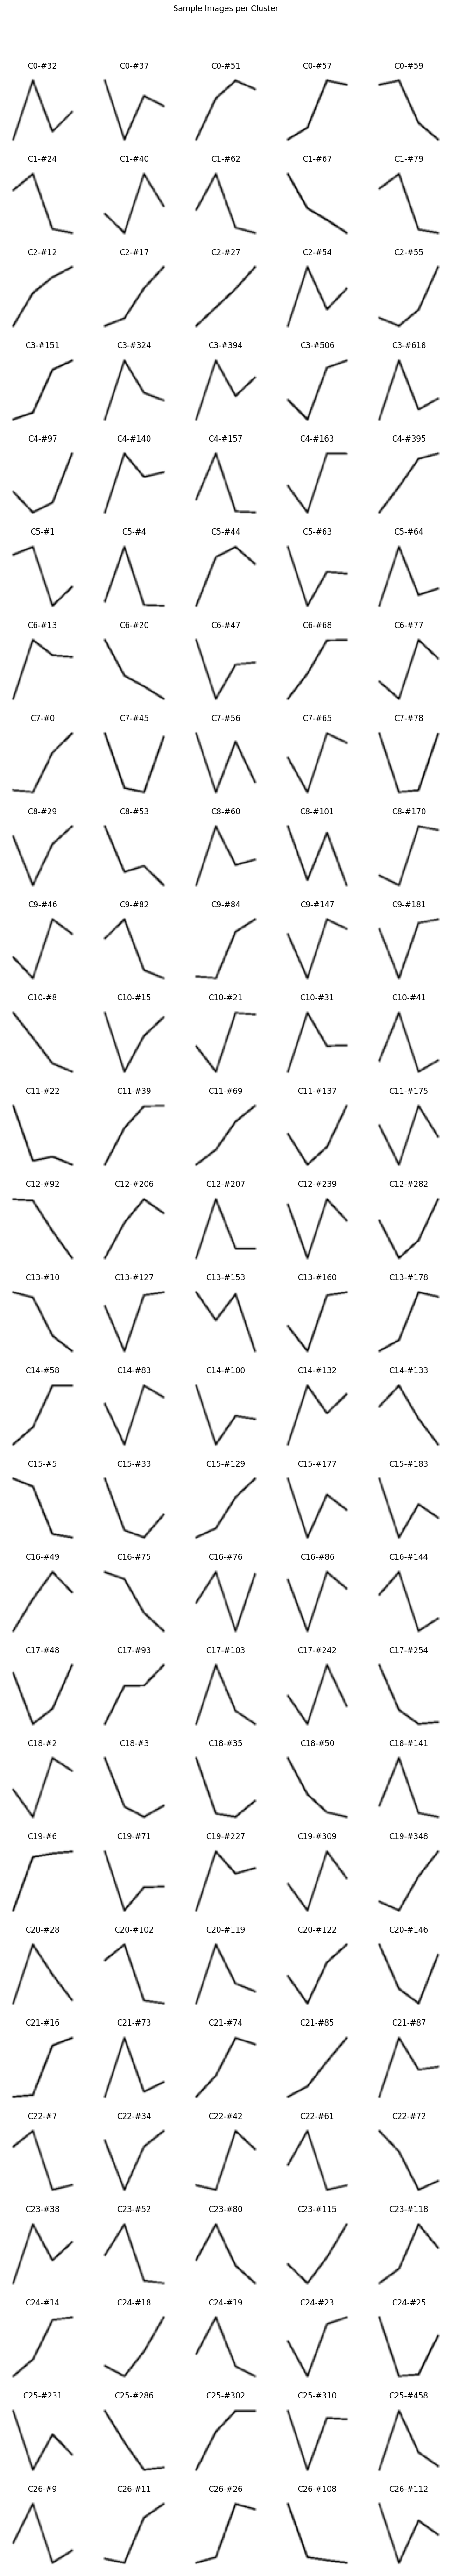

In [15]:
import matplotlib.pyplot as plt

# Assume `X_tensor` is your original image tensor [N, 1, 64, 64]
# Replace this with however you're storing images
samples_per_cluster = 5
fig, axes = plt.subplots(k, samples_per_cluster, figsize=(samples_per_cluster*2, k*2))

for cluster_id in range(k):
    indices = (cluster_labels == cluster_id).nonzero()[0]
    chosen = indices[:samples_per_cluster]

    for j, idx in enumerate(chosen):
        ax = axes[cluster_id, j]
        ax.imshow(X_tensor[idx][0].cpu().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'C{cluster_id}-#{idx}')

plt.tight_layout()
plt.suptitle("Sample Images per Cluster", y=1.02)
plt.show()


In [16]:


k = 27
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(latent_matrix)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_getbuffer at 0x7886c606b9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/llvmlite/binding/executionengine.py", line 207, in _raw_object_cache_getbuffer
    raise RuntimeError("object compilation notification "
RuntimeError: object compilation notification for unknown module <llvmlite.binding.ffi.LP_LLVMModule object at 0x78858523bd10>
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7886c606b920>
Traceback (most recent call last):
  Fi

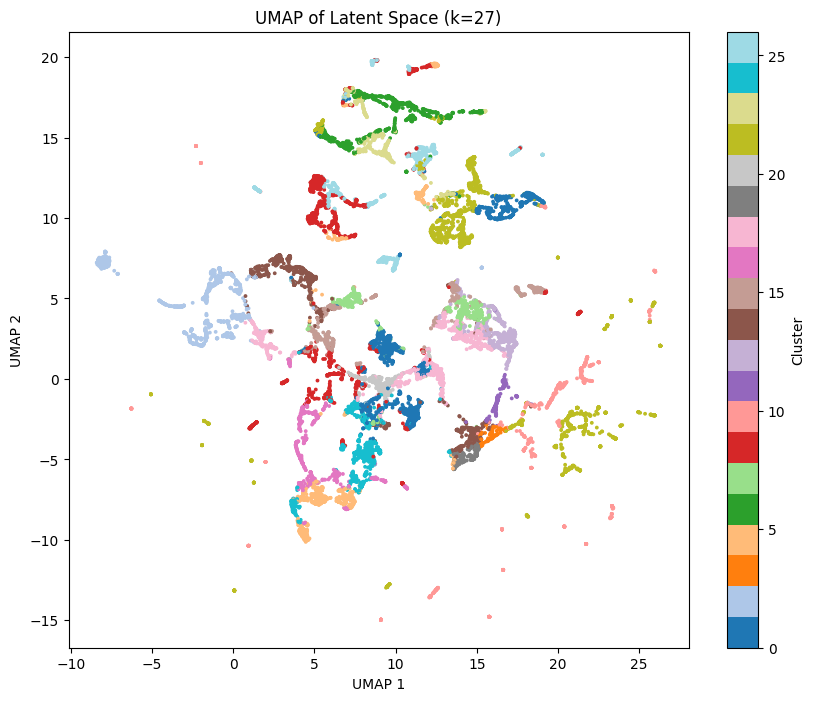

In [17]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(latent_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='tab20', s=3)
plt.title(f"UMAP of Latent Space (k={k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

k = 175
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(latent_matrix)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


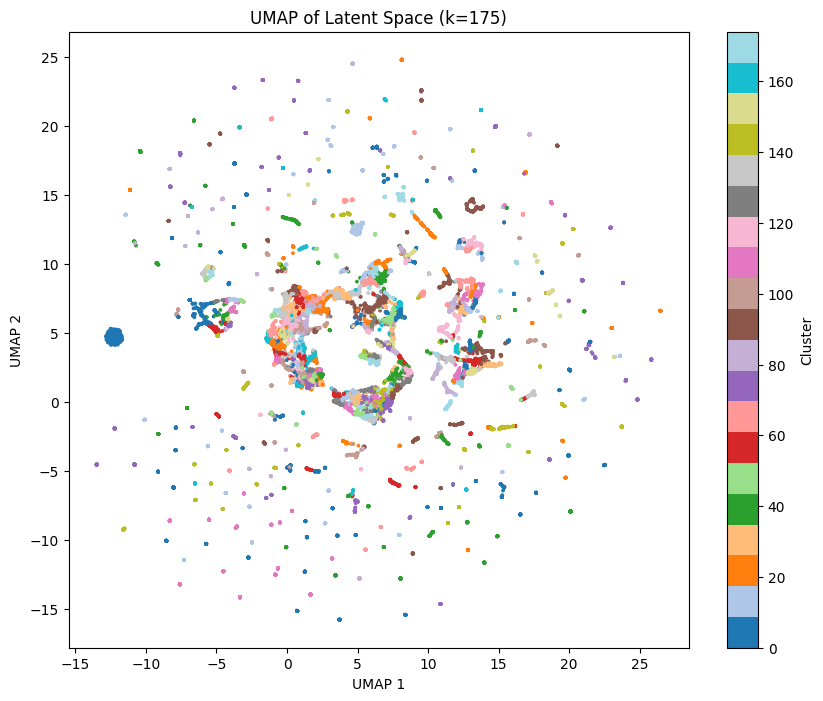

In [ ]:

reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(latent_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='tab20', s=3)
plt.title(f"UMAP of Latent Space (k={k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
!pip install hdbscan
